## Övning 3. Förutsäga Diabetes bland Pima indianer - Model explainability

- Vi ska predicera förekomsten av diabetes bland kvinnor med Pima Indiansk härkomst
- Syftet är att snabbt skapa ett neuralt nätverk för att sedan fokusera på att förklara vår modell mha Shapley-värden


### Kontext och data

Vi har hämtat datat från Kaggle, en hemsida man som utlyser allmänna tävlingar i prediktiva modeller.

Datat kommer ursprungligen från "National Institute of Diabetes and Digestive and Kidneys Disneys". Målet med övningen är att diagnostiskt förutsäga om en patient har diabetes ("Outcome"=1), baserat på individernas BMI, insulinnivå, ålder m.m. som ingår i datasatsen. Alla patienter är kvinnor som är minst 21 år gamla med Pima Indiansk härkomst.

Data & info: https://www.kaggle.com/uciml/pima-indians-diabetes-database/data#


## Påbörja analysen


### Importera bibliotek

Vi importerar de grundläggande bibliotek som vi använder och importerar vårt data 'diabetes.csv'

- Pandas är i Python-världen vad tidyverse är i R: det populäraste biblioteket för att hantera data i dataframes
- Importerar matplotlib för skapande av grafer 
- Importerar tensorflow,vårt "backend" för neurala nätverk
- Importerar numpy för matris-operationer



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import numpy as np


#Bestämmer seed inför sampling
seed = 444
#Anger seed för tensorflow respektive numpy-beräkningar
tf.random.set_seed(seed)
np.random.seed(seed)


## Hjälpfunktioner

- Används senare för att plotta modellutvärdering

In [2]:
def plot_training():
    
    print("accuracy, train: ", history.history['accuracy'][-1])
    print("accuracy, test: ", history.history['val_accuracy'][-1])
    
    # Credd : https://janakiev.com/notebooks/keras-iris/
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

## Importera data

Läser in diabetes csv-filen 'diabetes.csv' till dataframe "df"

In [3]:
url = 'https://raw.githubusercontent.com/DavidRyden/block5-2020sept/master/diabetes.csv'

df = pd.read_csv(url, delimiter=',')

 
#### Utforska datasetet
 
Vi har ett litet dataset på 768 observationer med 9 variabler, där Outcome innebär att man har diabetes(=1) eller inte (=0)

#####  5 första raderna

In [4]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


##### Deskriptiv statistik

In [18]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


#### Skapa train och valideringsdata

Likt övning 1 skapar vi träning och test-data

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Anger att 30% av data ska användas som test
test_prop = 0.3

labels=df['Outcome']
features = df.drop('Outcome', axis=1).astype('float64')

X=features

y=np.ravel(labels)

# Standardiserar data till medelvärde 0 och varians 1 
# Standardisering av värden hjälper neurala nätverk att konvergera
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, y, test_size=test_prop, random_state=seed)



#### Skapa en enkel model

Vi skapar en model med fyra hidden layers med 6 neuroner, ReLU som activation och l1 och l2-regularisering

Då vi utför en binär klassificering består output-lagret av en neuron med sigmoid activation

In [20]:
#import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import L1L2

model = Sequential()


# Storlek på Neuralt Nätverk
antal_hidden_layer = 4 # Djup
antal_noder = 6 # Bredd per lager

#Regulariseringsparametrar
l1_reg_rate = 0.001
l2_reg_rate = 0.01

# Definiera forward propagation
model = Sequential()

# Input lager 
model.add(Dense(antal_noder, input_dim=8, activation='relu'))

#Hidden lager
for l in range(antal_hidden_layer):
    model.add(Dense(antal_noder, activation='relu', kernel_regularizer=L1L2(l1=l1_reg_rate, l2=l2_reg_rate)))

#Output lager
model.add(Dense(1, activation='sigmoid'))


# Använder samma loss, optimizer och metric-settings som vid binär logistisk regression
model.compile(loss='binary_crossentropy',
              optimizer= 'sgd',  #RMSprop
              metrics=['accuracy'])

model.summary()



Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 6)                 54        
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 42        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 7         
Total params: 229
Trainable params: 229
Non-trainable params: 0
________________________________________________________

#### Träna modellen

In [21]:
        
history = model.fit(X_train, Y_train,epochs=500,  validation_data=(X_test, Y_test) )  #batch_size=16, verbose=1,

Train on 537 samples, validate on 231 samples
Epoch 1/500
537/537 [==============================] - ETA: 10s - loss: 0.9894 - accuracy: 0.593 - ETA: 0s - loss: 0.9833 - accuracy: 0.668 - 1s 2ms/sample - loss: 0.9823 - accuracy: 0.6741 - val_loss: 0.9732 - val_accuracy: 0.7013
Epoch 2/500
537/537 [==============================] - ETA: 0s - loss: 0.9781 - accuracy: 0.68 - 0s 149us/sample - loss: 0.9747 - accuracy: 0.6629 - val_loss: 0.9634 - val_accuracy: 0.6883
Epoch 3/500
537/537 [==============================] - ETA: 0s - loss: 0.9725 - accuracy: 0.68 - 0s 134us/sample - loss: 0.9681 - accuracy: 0.6387 - val_loss: 0.9550 - val_accuracy: 0.6926
Epoch 4/500
537/537 [==============================] - ETA: 0s - loss: 0.9452 - accuracy: 0.68 - 0s 132us/sample - loss: 0.9624 - accuracy: 0.6331 - val_loss: 0.9474 - val_accuracy: 0.6926
Epoch 5/500
537/537 [==============================] - ETA: 0s - loss: 0.9724 - accuracy: 0.56 - 0s 137us/sample - loss: 0.9571 - accuracy: 0.6331 - val_lo

537/537 [==============================] - ETA: 0s - loss: 0.7466 - accuracy: 0.68 - ETA: 0s - loss: 0.7030 - accuracy: 0.77 - 0s 202us/sample - loss: 0.7187 - accuracy: 0.7505 - val_loss: 0.6926 - val_accuracy: 0.7662
Epoch 86/500
537/537 [==============================] - ETA: 0s - loss: 0.6349 - accuracy: 0.87 - 0s 102us/sample - loss: 0.7173 - accuracy: 0.7542 - val_loss: 0.6910 - val_accuracy: 0.7662
Epoch 87/500
537/537 [==============================] - ETA: 0s - loss: 0.7574 - accuracy: 0.71 - ETA: 0s - loss: 0.7189 - accuracy: 0.75 - 0s 182us/sample - loss: 0.7157 - accuracy: 0.7542 - val_loss: 0.6896 - val_accuracy: 0.7619
Epoch 88/500
537/537 [==============================] - ETA: 0s - loss: 0.8724 - accuracy: 0.65 - 0s 137us/sample - loss: 0.7144 - accuracy: 0.7542 - val_loss: 0.6881 - val_accuracy: 0.7619
Epoch 89/500
537/537 [==============================] - ETA: 0s - loss: 0.7195 - accuracy: 0.75 - 0s 134us/sample - loss: 0.7129 - accuracy: 0.7561 - val_loss: 0.6863 - 

Epoch 128/500
537/537 [==============================] - ETA: 0s - loss: 0.6344 - accuracy: 0.75 - 0s 124us/sample - loss: 0.6571 - accuracy: 0.7672 - val_loss: 0.6357 - val_accuracy: 0.7835
Epoch 129/500
537/537 [==============================] - ETA: 0s - loss: 0.6535 - accuracy: 0.78 - 0s 130us/sample - loss: 0.6561 - accuracy: 0.7691 - val_loss: 0.6345 - val_accuracy: 0.7879
Epoch 130/500
537/537 [==============================] - ETA: 0s - loss: 0.6503 - accuracy: 0.78 - 0s 154us/sample - loss: 0.6544 - accuracy: 0.7672 - val_loss: 0.6337 - val_accuracy: 0.7835
Epoch 131/500
537/537 [==============================] - ETA: 0s - loss: 0.6652 - accuracy: 0.78 - 0s 108us/sample - loss: 0.6533 - accuracy: 0.7672 - val_loss: 0.6324 - val_accuracy: 0.7835
Epoch 132/500
537/537 [==============================] - ETA: 0s - loss: 0.5941 - accuracy: 0.84 - 0s 84us/sample - loss: 0.6516 - accuracy: 0.7691 - val_loss: 0.6314 - val_accuracy: 0.7792
Epoch 133/500
537/537 [=======================

537/537 [==============================] - ETA: 0s - loss: 0.6825 - accuracy: 0.78 - 0s 57us/sample - loss: 0.5752 - accuracy: 0.7728 - val_loss: 0.5772 - val_accuracy: 0.7965
Epoch 215/500
537/537 [==============================] - ETA: 0s - loss: 0.5405 - accuracy: 0.81 - 0s 57us/sample - loss: 0.5745 - accuracy: 0.7709 - val_loss: 0.5766 - val_accuracy: 0.7965
Epoch 216/500
537/537 [==============================] - ETA: 0s - loss: 0.6909 - accuracy: 0.59 - 0s 55us/sample - loss: 0.5739 - accuracy: 0.7747 - val_loss: 0.5767 - val_accuracy: 0.7965
Epoch 217/500
537/537 [==============================] - ETA: 0s - loss: 0.6127 - accuracy: 0.71 - 0s 82us/sample - loss: 0.5735 - accuracy: 0.7709 - val_loss: 0.5765 - val_accuracy: 0.7965
Epoch 218/500
537/537 [==============================] - ETA: 0s - loss: 0.5790 - accuracy: 0.75 - 0s 84us/sample - loss: 0.5730 - accuracy: 0.7747 - val_loss: 0.5758 - val_accuracy: 0.7965
Epoch 219/500
537/537 [==============================] - ETA: 0s

537/537 [==============================] - ETA: 0s - loss: 0.5662 - accuracy: 0.78 - 0s 73us/sample - loss: 0.5390 - accuracy: 0.7821 - val_loss: 0.5523 - val_accuracy: 0.8009
Epoch 301/500
537/537 [==============================] - ETA: 0s - loss: 0.4910 - accuracy: 0.78 - 0s 54us/sample - loss: 0.5388 - accuracy: 0.7840 - val_loss: 0.5518 - val_accuracy: 0.7965
Epoch 302/500
537/537 [==============================] - ETA: 0s - loss: 0.5034 - accuracy: 0.81 - 0s 62us/sample - loss: 0.5386 - accuracy: 0.7877 - val_loss: 0.5508 - val_accuracy: 0.7965
Epoch 303/500
537/537 [==============================] - ETA: 0s - loss: 0.6984 - accuracy: 0.62 - 0s 60us/sample - loss: 0.5385 - accuracy: 0.7821 - val_loss: 0.5505 - val_accuracy: 0.7965
Epoch 304/500
537/537 [==============================] - ETA: 0s - loss: 0.5723 - accuracy: 0.75 - 0s 80us/sample - loss: 0.5377 - accuracy: 0.7877 - val_loss: 0.5501 - val_accuracy: 0.7965
Epoch 305/500
537/537 [==============================] - ETA: 0s

537/537 [==============================] - ETA: 0s - loss: 0.4876 - accuracy: 0.81 - 0s 78us/sample - loss: 0.5184 - accuracy: 0.7858 - val_loss: 0.5396 - val_accuracy: 0.7879
Epoch 387/500
537/537 [==============================] - ETA: 0s - loss: 0.6002 - accuracy: 0.68 - 0s 71us/sample - loss: 0.5186 - accuracy: 0.7896 - val_loss: 0.5389 - val_accuracy: 0.7835
Epoch 388/500
537/537 [==============================] - ETA: 0s - loss: 0.4320 - accuracy: 0.78 - 0s 54us/sample - loss: 0.5183 - accuracy: 0.7821 - val_loss: 0.5394 - val_accuracy: 0.7879
Epoch 389/500
537/537 [==============================] - ETA: 0s - loss: 0.5423 - accuracy: 0.75 - 0s 82us/sample - loss: 0.5180 - accuracy: 0.7877 - val_loss: 0.5399 - val_accuracy: 0.7879
Epoch 390/500
537/537 [==============================] - ETA: 0s - loss: 0.7735 - accuracy: 0.62 - 0s 54us/sample - loss: 0.5181 - accuracy: 0.7914 - val_loss: 0.5393 - val_accuracy: 0.7879
Epoch 391/500
537/537 [==============================] - ETA: 0s

Epoch 472/500
537/537 [==============================] - ETA: 0s - loss: 0.4521 - accuracy: 0.87 - 0s 56us/sample - loss: 0.5061 - accuracy: 0.7914 - val_loss: 0.5332 - val_accuracy: 0.7835
Epoch 473/500
537/537 [==============================] - ETA: 0s - loss: 0.4740 - accuracy: 0.84 - 0s 84us/sample - loss: 0.5066 - accuracy: 0.7933 - val_loss: 0.5332 - val_accuracy: 0.7835
Epoch 474/500
537/537 [==============================] - ETA: 0s - loss: 0.5997 - accuracy: 0.68 - 0s 55us/sample - loss: 0.5063 - accuracy: 0.7896 - val_loss: 0.5330 - val_accuracy: 0.7835
Epoch 475/500
537/537 [==============================] - ETA: 0s - loss: 0.5524 - accuracy: 0.71 - 0s 57us/sample - loss: 0.5059 - accuracy: 0.7877 - val_loss: 0.5335 - val_accuracy: 0.7835
Epoch 476/500
537/537 [==============================] - ETA: 0s - loss: 0.4159 - accuracy: 0.87 - 0s 82us/sample - loss: 0.5061 - accuracy: 0.7933 - val_loss: 0.5341 - val_accuracy: 0.7835
Epoch 477/500
537/537 [===========================

#### Utvärdering
 - Hur ser accuracy och loss ut för tränings- och valideringsdata?

accuracy, train:  0.7914339
accuracy, test:  0.7835498


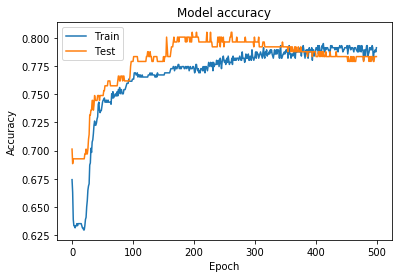

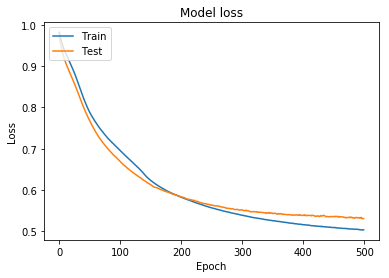

In [22]:
plot_training()

#### Skapa prediktioner på vårt test-data


In [23]:
#Skapa prediktioner för testdata
x_test_pred = (model.predict(X_test) > 0.5).astype("int32")

# Visa predicerad output
print("Exempel, 3 första observationerna: \n")
for i in range(3):
    print("X=%s \n\n Y=%s, Predicted=%s \n" % (X_test[i], Y_test[i] , x_test_pred[i]))

Exempel, 3 första observationerna: 

X=[-1.14185152  1.28648383  0.35643175  0.96999799 -0.69289057  2.2347207
 -0.32579923 -0.61611067] 

 Y=1, Predicted=[1] 

X=[ 1.53084665  1.97502103  0.8217115  -0.3472913  -0.69289057 -0.25289651
  2.23828152  1.34090765] 

 Y=1, Predicted=[1] 

X=[-1.14185152 -0.05929342 -0.26394125 -0.15910711  0.10593585  0.36900779
  0.76446361 -0.87137393] 

 Y=0, Predicted=[0] 



## Deep learning - Explainability

För bara några år sedan var det accepterat att använda sig av Deep learning-modeller utan krav på att förklara hur de fungerade. Man accepterade att de var "Black box"-modeller som presterade bra. 

Numera har Explainability blivit väldigt populärt inom deep learning. LIME (Local Interpretable Model-agnostic Explanations) och Shapley-värden är exempel på metoder som "approximerar" våra ML-modeller och förklarar vilka features som är drivande. Den tekniska definitionen av Shapley-värden är “det genomsnittliga marginella bidraget en feature har över alla möjliga kombinationer”



##### SHAP (SHapley Additive exPlanation)

- Vi väljer här att redovisa hur Shapley-värden fungerar, för att ge ett konkret vad Deep learning explainability handlar om


- Det finns ett praktiskt Python-bibliotek, SHAP, som är populärt att använda. Det skapades av Scott Lundberg, Senior Researcher vid Microsoft Research och är i dagsläget ett av de mest populära biblioteken för ändamålet


- Model Explainability är dock ett område som förbättras väldigt mycket och väldigt snabbt, det är troligt branschstandarderna kommer att förändras. Exempelvis är det troligt att Tensorboard, skapat av Google som ett komplement till Tensorflow, blir betydligt mer populärt på området Model Explainability. 


#### Länkar för den som vill veta mer

Om SHAP: https://github.com/slundberg/shap

Om Tensorboard: https://www.tensorflow.org/tensorboard/what_if_tool







#### Importera bibliotek

Importerar biblioteket shap

In [24]:
#!pip install shap
import shap

# För att javascript ska fungera i notebooken
shap.initjs()

### Information som krävs

- Vi föder vår Shapley-explainer med träningsdatasetet, aggregerat ned till färre kluster istället för alla observationer med hjälp av k-means

- Vi anger även modellen som vi tränat på vårt träningsdata


In [25]:
df_test = pd.DataFrame(data=X_test,  columns=features.columns.array) 

# använder kmeans för att aggregera data för snabbare beräkning
X_train_summary = shap.kmeans(X_train, 100)
 
# Vi föder vår explainer med träningsdata och dess model-prediktioner
explainer = shap.KernelExplainer(model.predict,X_train_summary)
#Beräknar Shapley-värden på test-datasetet
shap_values_model_val = explainer.shap_values(X_test,l1_reg="num_features(8)")

### Utvärdera effekt av features

Med SHAP kan vi både utforska och förklara enskilda observationer, men även hela data-setet



##### Enskild  observation

- Vi kan nu välja en observation och få förklaringen till varför observation avviker från vårt base-value.

- Röda värden ökar sannolikheten för diabetes, medan blå värden minskar den

- Kom ihåg att våra variabler är standardiserade: negativt värde betyder under genomsnittet och positivt värde tvärtom

- Notera att SHAP är modell-agnostiskt och en approximation. Detta är alltså inte den EXAKTA sanningen, men ger en bra bild av hur våra features samverkar.


In [26]:
shap.initjs()

obs = 14 #Vald observation

shap_values = explainer.shap_values(X_test[obs,:],l1_reg="num_features(8)")
shap.force_plot(explainer.expected_value[0], shap_values[0], df_test.iloc[[obs]])

##### Alla observationer

- Tänk dig att vi vrider ovan enskilda observation 90 grader och staplar alla observationer i valideringsdata efter varandra


- Grafen är interaktiv, vilket innebär att du kan utforska hur features samverkar i olika skärningar
- testa att byta ut "sample order by similarity" till "Glucose": du ser att glukos-värden som är under medelvärdet (=under 0) bidrar till minskad risk för diabetes och tvärtom
- Byt nu ut Y-axels "Output value" till "Glucose effects" för att tydliggöra sambandet

In [27]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values_model_val[0], df_test)

För att få en överblick över vilka features som har störst påverkan på vår output prediction så kan vi ta fram nedan plot. Exempelvis är det tydligt att höga glukosvärden ökar risken för diabetes och vice versa. 

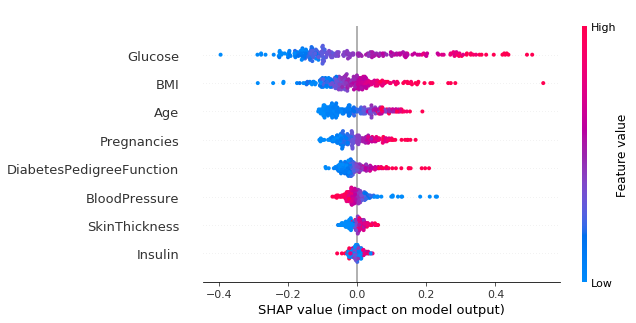

In [28]:
shap.summary_plot(shap_values_model_val[0], df_test)

Vi kan även visualisera detta samband och jämföra detta med en interaktionsvariabel. 

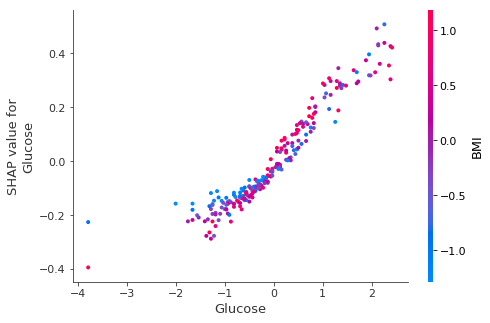

In [29]:
shap.dependence_plot("Glucose", shap_values_model_val[0], df_test)

 .

 .

### Slutsats

- I denna övning har vi snabbt skapat en duglig model för att predicera diabetes


- Vi har sedan fokuserat på Shapley-värden och möjligheten att förklara komplexa neurala nätverk genom approximering


- Det finns redan idag bra möjligheter till tolkning av "black box"-modeller, och området förbättras i rask takt


 .